In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  !pip install -q pyomo
  !wget -N -q "https://github.com/thomasfork/ipopt_linux/raw/main/ipopt-linux64.zip"
  !unzip -o -q ipopt-linux64

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from pyomo.environ import *

#Dataset
file_path = "features_3_sec.csv"  #Adjust the path if needed
data = pd.read_csv(file_path)

#Preprocessing
X = data.drop(columns=["filename", "label"])  #Features
y = data["label"]  #Labels

#Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

#Initialize models for each pair of classes
num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]
ovo_models = {}

#Train a Pyomo-based SVM for each pair of classes
for i in range(num_classes):
    for j in range(i + 1, num_classes):
        #Filter the data for classes i and j
        idx = np.where((y_train == i) | (y_train == j))[0]
        X_pair = X_train[idx]
        y_pair = y_train[idx]
        y_pair = np.where(y_pair == i, 1, -1)  # Binary labels

        #Define the Pyomo model
        model = ConcreteModel()

        #variables
        model.w = Var(range(num_features), domain=Reals)
        model.b = Var(domain=Reals)
        model.xi = Var(range(len(X_pair)), domain=NonNegativeReals)

        #Hyperparameter for regularization
        C = 1.0

        #Objective function
        model.obj = Objective(
            expr=sum(model.w[k]**2 for k in range(num_features)) / 2 +
                 C * sum(model.xi[i] for i in range(len(X_pair))),
            sense=minimize
        )

        #Constraints
        model.constraints = ConstraintList()
        for k in range(len(X_pair)):
            model.constraints.add(
                y_pair[k] * (
                    sum(model.w[m] * X_pair[k, m] for m in range(num_features)) + model.b
                ) >= 1 - model.xi[k]
            )

        #Solve the model
        solver = SolverFactory('ipopt')
        solver.solve(model)

        #Store the trained model parameters
        ovo_models[(i, j)] = {
            'w': np.array([value(model.w[k]) for k in range(num_features)]),
            'b': value(model.b)
        }

#Function
def ovo_predict(X, models, num_classes):
    votes = np.zeros((X.shape[0], num_classes))
    for (i, j), params in models.items():
        w, b = params['w'], params['b']
        decision = np.dot(X, w) + b
        votes[:, i] += (decision > 0).astype(int)
        votes[:, j] += (decision <= 0).astype(int)
    return np.argmax(votes, axis=1)

#Test the model
y_pred = ovo_predict(X_test, ovo_models, num_classes)

accuracy = np.mean(y_pred == y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 77.13%


In [ ]:
from sklearn.metrics import classification_report

def ovo_predict(X, models, num_classes):
    votes = np.zeros((X.shape[0], num_classes))
    for (i, j), params in models.items():
        w, b = params['w'], params['b']
        decision = np.dot(X, w) + b
        votes[:, i] += (decision > 0).astype(int)
        votes[:, j] += (decision <= 0).astype(int)
    return np.argmax(votes, axis=1)

y_pred = ovo_predict(X_test, ovo_models, num_classes)

report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
print(report)

              precision    recall  f1-score   support

       blues       0.72      0.79      0.76       208
   classical       0.90      0.95      0.93       203
     country       0.65      0.72      0.68       186
       disco       0.69      0.70      0.69       199
      hiphop       0.78      0.76      0.77       218
        jazz       0.85      0.85      0.85       192
       metal       0.86      0.87      0.86       204
         pop       0.83      0.88      0.85       180
      reggae       0.78      0.64      0.70       211
        rock       0.64      0.55      0.60       197

    accuracy                           0.77      1998
   macro avg       0.77      0.77      0.77      1998
weighted avg       0.77      0.77      0.77      1998



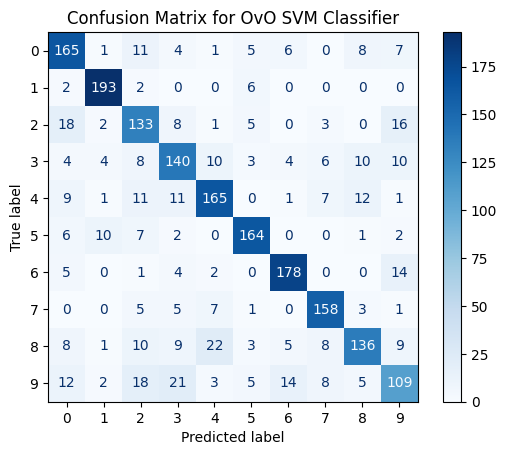

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_test, y_pred, num_classes):
    cm = confusion_matrix(y_test, y_pred, labels=np.arange(num_classes))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(num_classes))
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix for OvO SVM Classifier")
    plt.show()

plot_confusion_matrix(y_test, y_pred, num_classes)